In [2]:
import os
import warnings

import matplotlib.pyplot as plt
import pandas as pd
from tqdm.auto import tqdm

warnings.filterwarnings("ignore")

C:\Users\saoedoss\AppData\Roaming\Python\Python310\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
from darts import TimeSeries
from darts.models import (
    ARIMA,
    FFT,
    AutoARIMA,
    ExponentialSmoothing,
    NaiveDrift,
    NaiveMean,
    NaiveMovingAverage,
    NaiveSeasonal,
    Theta,
)
from darts.utils.statistics import check_seasonality

In [4]:
import sys

# Adicionar a pasta 'src' ao caminho do sistema
sys.path.append(os.path.abspath(os.path.join("..", "src")))

# Agora você pode importar o módulo utils Ou importar funções específicas do módulo
from metrics import LogTime, eval_model
from ts_plots import plot_forecast

In [5]:
checkpoints_path = os.path.join(os.pardir, "checkpoints")
df_static = pd.read_parquet(os.path.join(checkpoints_path, "5G_df_static.parquet.gzip"))

In [6]:
target_columns = ["RSRP", "RSRQ", "SNR", "CQI", "RSSI"]

In [7]:
static_uids = sorted(df_static.Uid.unique().tolist())
display(static_uids)

['45tHAXkk',
 '4u4uNEHg',
 'AMcyZBRZ',
 'CSyiTD67',
 'FWgQihFY',
 'GkLNvAxk',
 'JX5ctgXk',
 'Jg5gZWT9',
 'JuJhmMUS',
 'KWkqdhLs',
 'L2Gc6KFE',
 'NNM8S6cc',
 'ThHnpx5h',
 'VVtpjXhe',
 'X5rS2fPs',
 'Zk7wQePj',
 'aTx448ZX',
 'eoHUrkbG',
 'in2JGSH5',
 'j9aQcpma',
 'm3xmyiFu',
 'mDVN6DYG',
 'nQK8dP5x']

In [8]:
test_df = (
    df_static[df_static.Uid == static_uids[10]][target_columns].asfreq(freq="S").bfill()
)

In [9]:
test_df

,RSRP,RSRQ,SNR,CQI,RSSI
Timestamp,,,,,
2019-11-28 09:21:45,-88.0,-14.0,-3.0,8.0,-70.0
2019-11-28 09:21:46,-88.0,-14.0,-3.0,8.0,-70.0
2019-11-28 09:21:47,-89.0,-14.0,-1.0,5.0,-72.0
2019-11-28 09:21:48,-89.0,-14.0,-1.0,5.0,-72.0
2019-11-28 09:21:49,-87.0,-13.0,-3.0,4.0,-70.0
...,...,...,...,...,...
2019-11-28 10:10:35,-89.0,-14.0,10.0,9.0,-68.0
2019-11-28 10:10:36,-89.0,-14.0,10.0,9.0,-68.0
2019-11-28 10:10:37,-89.0,-12.0,3.0,9.0,-68.0


<Axes: xlabel='Timestamp'>

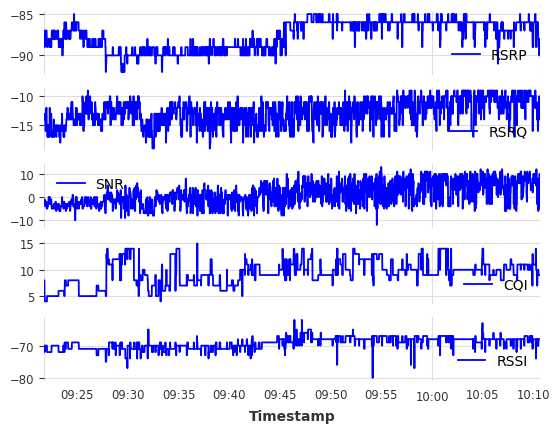

In [10]:
fig, ax = plt.subplots(5, 1)
test_df.plot(kind="line", sharex=True, y="RSRP", color="b", ax=ax[0])
test_df.plot(kind="line", sharex=True, y="RSRQ", color="b", ax=ax[1])
test_df.plot(kind="line", sharex=True, y="SNR", color="b", ax=ax[2])
test_df.plot(kind="line", sharex=True, y="CQI", color="b", ax=ax[3])
test_df.plot(kind="line", sharex=True, y="RSSI", color="b", ax=ax[4])

In [11]:
ts_static = TimeSeries.from_dataframe(
    test_df,
    value_cols=["RSRP", "RSRQ", "SNR", "CQI", "RSSI"],
    # fill_missing_dates=True,  # Adiciona NaN para os segundos ausentes
    # freq="s",
)

# Split Train/Test

In [12]:
# Separar os timeseries
ts_train, ts_actual = ts_static.split_after(0.8)

# Univariate (RSRP)

<Axes: xlabel='Timestamp'>

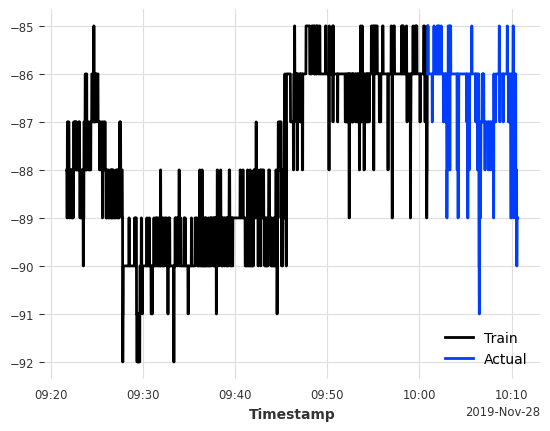

In [13]:
ts_train["RSRP"].plot(label="Train")
ts_actual["RSRP"].plot(label="Actual")

# Multivariate (RSRP, RSRQ, SNR, CQI, RSSI)

<Axes: xlabel='Timestamp'>

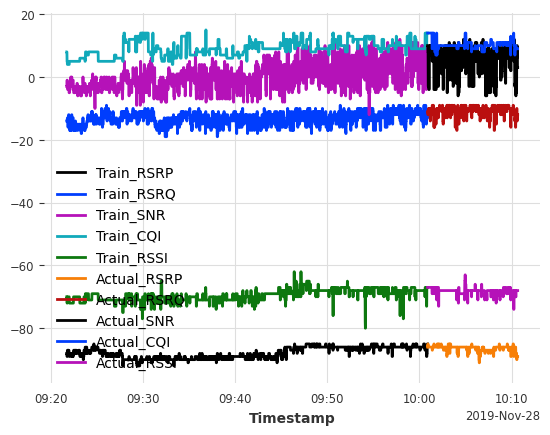

In [14]:
ts_train.plot(label="Train")
ts_actual.plot(label="Actual")

In [15]:
# Check Seasonality
for col in ts_train.columns:
    display(f"{col}: Check Seasonality: {check_seasonality(ts_train[col])}")

'RSRP: Check Seasonality: (False, 0)'

'RSRQ: Check Seasonality: (True, 12)'

'SNR: Check Seasonality: (True, 9)'

'CQI: Check Seasonality: (False, 0)'

'RSSI: Check Seasonality: (True, 16)'

# Baseline Forecast

In [16]:
metric_record = []

## Naive Forecast

---

Example only for RSRP

In [17]:
uni_variable = "RSRP"
name = "Naive"
naive_model = NaiveSeasonal(K=1)
with LogTime() as timer:
    y_pred, metrics = eval_model(
        naive_model, ts_train[uni_variable], ts_actual[uni_variable], name=name
    )

Time Elapsed: 0 microseconds


In [18]:
metrics

{'Algorithm': 'Naive',
 'MAE': 1.434412265758092,
 'MSE': 2.93015332197615,
 'MASE': 6.6664665103648355}

<Axes: xlabel='Timestamp'>

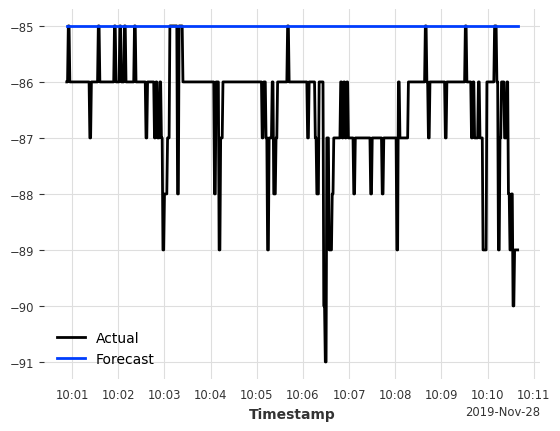

In [19]:
ts_actual["RSRP"].plot(label="Actual")
y_pred["RSRP"].plot(label="Forecast")

---

For all Channel Quality KPIs

## Naive

In [20]:
name = "Naive"
naive_model = NaiveSeasonal(K=1)
with LogTime() as timer:
    y_pred, metrics = eval_model(naive_model, ts_train, ts_actual, name=name)
metrics["Time Elapsed"] = timer.elapsed
display(metrics)

Time Elapsed: 0 microseconds


{'Algorithm': 'Naive',
 'MAE': 2.5243611584327086,
 'MSE': 11.686882453151616,
 'MASE': 6.580801136290491,
 'Time Elapsed': 0.012911081314086914}

In [21]:
metric_record.append(metrics)
metrics_df = pd.DataFrame(metric_record).set_index("Algorithm")
metrics_df.style.highlight_min()

,MAE,MSE,MASE,Time Elapsed
Algorithm,,,,
Naive,2.524361,11.686882,6.580801,0.012911


In [22]:
fig = plot_forecast(
    ts_actual,
    y_pred,
    title=f"{name}: MAE: {metrics['MAE']:.4f} | MSE: {metrics['MSE']:.4f} | MASE: {metrics['MASE']:.4f}",
)
fig.show()
# fig.write_image("imgs/chapter_4/ma.png")

## Naive Drift

In [23]:
name = "Naive Drift"
naive_model = NaiveDrift()
with LogTime() as timer:
    y_pred, metrics = eval_model(naive_model, ts_train, ts_actual, name=name)
metrics["Time Elapsed"] = timer.elapsed
display(metrics)

Time Elapsed: 0 microseconds


{'Algorithm': 'Naive Drift',
 'MAE': 2.948842155232422,
 'MSE': 15.453931584829173,
 'MASE': 7.9116678232942075,
 'Time Elapsed': 0.010805368423461914}

In [24]:
metric_record.append(metrics)
metrics_df = pd.DataFrame(metric_record).set_index("Algorithm")
display(metrics_df.style.highlight_min())

,MAE,MSE,MASE,Time Elapsed
Algorithm,,,,
Naive,2.524361,11.686882,6.580801,0.012911
Naive Drift,2.948842,15.453932,7.911668,0.010805


In [25]:
fig = plot_forecast(
    ts_actual,
    y_pred,
    title=f"{name}: MAE: {metrics['MAE']:.4f} | MSE: {metrics['MSE']:.4f} | MASE: {metrics['MASE']:.4f}",
)
fig.show()
# fig.write_image("imgs/chapter_4/ma.png")

## Naive Moving Average

In [26]:
name = "Naive Moving Average"
naive_model = NaiveMovingAverage(6)
with LogTime() as timer:
    y_pred, metrics = eval_model(naive_model, ts_train, ts_actual, name=name)
metrics["Time Elapsed"] = timer.elapsed
display(metrics)

Time Elapsed: 0 microseconds


{'Algorithm': 'Naive Moving Average',
 'MAE': 2.192078524865087,
 'MSE': 9.25335136218502,
 'MASE': 5.531168925533716,
 'Time Elapsed': 0.012846708297729492}

In [27]:
metric_record.append(metrics)
metrics_df = pd.DataFrame(metric_record).set_index("Algorithm")
display(metrics_df.style.highlight_min())

,MAE,MSE,MASE,Time Elapsed
Algorithm,,,,
Naive,2.524361,11.686882,6.580801,0.012911
Naive Drift,2.948842,15.453932,7.911668,0.010805
Naive Moving Average,2.192079,9.253351,5.531169,0.012847


In [28]:
fig = plot_forecast(
    ts_actual,
    y_pred,
    title=f"{name}: MAE: {metrics['MAE']:.4f} | MSE: {metrics['MSE']:.4f} | MASE: {metrics['MASE']:.4f}",
)
fig.show()
# fig.write_image("imgs/chapter_4/ma.png")

## Seasonal Naive Forecast

In [29]:
name = "Seasonal Naive Forecast"
naive_model = NaiveSeasonal(K=60)
with LogTime() as timer:
    y_pred, metrics = eval_model(naive_model, ts_train, ts_actual, name=name)
metrics["Time Elapsed"] = timer.elapsed
display(metrics)

Time Elapsed: 0 microseconds


{'Algorithm': 'Seasonal Naive Forecast',
 'MAE': 2.142419080068143,
 'MSE': 11.72197614991482,
 'MASE': 4.377011033804945,
 'Time Elapsed': 0.01227712631225586}

In [30]:
metric_record.append(metrics)
metrics_df = pd.DataFrame(metric_record).set_index("Algorithm")
display(metrics_df.style.highlight_min())

,MAE,MSE,MASE,Time Elapsed
Algorithm,,,,
Naive,2.524361,11.686882,6.580801,0.012911
Naive Drift,2.948842,15.453932,7.911668,0.010805
Naive Moving Average,2.192079,9.253351,5.531169,0.012847
Seasonal Naive Forecast,2.142419,11.721976,4.377011,0.012277


In [31]:
fig = plot_forecast(
    ts_actual,
    y_pred,
    title=f"{name}: MAE: {metrics['MAE']:.4f} | MSE: {metrics['MSE']:.4f} | MASE: {metrics['MASE']:.4f}",
)
fig.show()
# fig.write_image("imgs/chapter_4/ma.png")

## Exponential Smoothing Forecast

Only supports univariate

In [32]:
from darts.utils.utils import ModelMode, SeasonalityMode

In [33]:
name = "Exponential Smoothing"
uni_variable = "RSRP"
# Suppress FutureWarning
# with warnings.catch_warnings():
#     warnings.filterwarnings("ignore", category=FutureWarning)

# ets_model = ExponentialSmoothing(
#     trend= ModelMode.ADDITIVE,
#     damped=True,
#     seasonal= SeasonalityMode.ADDITIVE,
#     seasonal_periods=10,
#     random_state=42,
# )

ets_model = ExponentialSmoothing(
    trend=ModelMode.ADDITIVE,
    seasonal=SeasonalityMode.ADDITIVE,
    seasonal_periods=7,
    random_state=42,
)
with LogTime() as timer:
    y_pred, metrics = eval_model(
        ets_model, ts_train["RSRP"], ts_actual["RSRP"], name=name
    )
metrics["Time Elapsed"] = timer.elapsed
display(metrics)

Time Elapsed: 0 microseconds


{'Algorithm': 'Exponential Smoothing',
 'MAE': 1.8246319369322814,
 'MSE': 4.380192196703086,
 'MASE': 8.480022091049634,
 'Time Elapsed': 0.6349034309387207}

In [34]:
metric_record.append(metrics)
metrics_df = pd.DataFrame(metric_record).set_index("Algorithm")
display(metrics_df.style.highlight_min())

,MAE,MSE,MASE,Time Elapsed
Algorithm,,,,
Naive,2.524361,11.686882,6.580801,0.012911
Naive Drift,2.948842,15.453932,7.911668,0.010805
Naive Moving Average,2.192079,9.253351,5.531169,0.012847
Seasonal Naive Forecast,2.142419,11.721976,4.377011,0.012277
Exponential Smoothing,1.824632,4.380192,8.480022,0.634903


In [35]:
fig = plot_forecast(
    ts_actual["RSRP"],
    y_pred,
    title=f"{name}: MAE: {metrics['MAE']:.4f} | MSE: {metrics['MSE']:.4f} | MASE: {metrics['MASE']:.4f}",
)
fig.show()

## ARIMA

Only supports univariate

> Preciso verificar quais parâmetros precisam ser aplicados ao AutoARIMA.

> ARIMA assume que a série é *estacionária*: que suas propriedades permanecem constantes pelo tempo.

In [36]:
name = "ARIMA"
# AutoARIMA will take a lot time for long time series
# arima_model = AutoARIMA(max_p=5, max_q=3, m=48, seasonal=False)
arima_model = ARIMA(p=2, d=1, q=1, seasonal_order=(1, 1, 1, 60))
# Taking only latest 8000 points for training (Time constraints)
# Reduce 8000 if it is taking too much time or consuming all the memory

with LogTime() as timer:
    y_pred, metrics = eval_model(
        arima_model, ts_train["RSRP"], ts_actual["RSRP"], name=name
    )
metrics["Time Elapsed"] = timer.elapsed
display(metrics)

Time Elapsed: 3 minutes and 52 seconds


{'Algorithm': 'ARIMA',
 'MAE': 0.7945353686781568,
 'MSE': 0.9801278579414389,
 'MASE': 3.6926227926487796,
 'Time Elapsed': 232.45152068138123}

In [37]:
metric_record.append(metrics)
metrics_df = pd.DataFrame(metric_record).set_index("Algorithm")
display(metrics_df.style.highlight_min())

,MAE,MSE,MASE,Time Elapsed
Algorithm,,,,
Naive,2.524361,11.686882,6.580801,0.012911
Naive Drift,2.948842,15.453932,7.911668,0.010805
Naive Moving Average,2.192079,9.253351,5.531169,0.012847
Seasonal Naive Forecast,2.142419,11.721976,4.377011,0.012277
Exponential Smoothing,1.824632,4.380192,8.480022,0.634903
ARIMA,0.794535,0.980128,3.692623,232.451521


In [38]:
y_pred.pd_dataframe()

component,RSRP
Timestamp,
2019-11-28 10:00:53,-85.906457
2019-11-28 10:00:54,-86.588576
2019-11-28 10:00:55,-86.724958
2019-11-28 10:00:56,-86.735972
2019-11-28 10:00:57,-86.695947
...,...
2019-11-28 10:10:35,-86.378171
2019-11-28 10:10:36,-86.455074
2019-11-28 10:10:37,-86.506320


In [39]:
fig = plot_forecast(
    ts_actual["RSRP"],
    y_pred,
    title=f"{name}: MAE: {metrics['MAE']:.4f} | MSE: {metrics['MSE']:.4f} | MASE: {metrics['MASE']:.4f}",
)
fig.show()

## Theta

Only supports univariate

> This model does not handle missing values.

In [40]:
name = "Theta"
theta_model = Theta(
    theta=3, seasonality_period=60, season_mode=SeasonalityMode.ADDITIVE
)
with LogTime() as timer:
    y_pred, metrics = eval_model(
        theta_model, ts_train["RSRP"], ts_actual["RSRP"], name=name
    )
metrics["Time Elapsed"] = timer.elapsed

Time Elapsed: 0 microseconds


In [41]:
metric_record.append(metrics)
metrics_df = pd.DataFrame(metric_record).set_index("Algorithm")
display(metrics_df.style.highlight_min())

,MAE,MSE,MASE,Time Elapsed
Algorithm,,,,
Naive,2.524361,11.686882,6.580801,0.012911
Naive Drift,2.948842,15.453932,7.911668,0.010805
Naive Moving Average,2.192079,9.253351,5.531169,0.012847
Seasonal Naive Forecast,2.142419,11.721976,4.377011,0.012277
Exponential Smoothing,1.824632,4.380192,8.480022,0.634903
ARIMA,0.794535,0.980128,3.692623,232.451521
Theta,1.709274,4.009997,7.943894,0.097764


In [42]:
fig = plot_forecast(
    ts_actual["RSRP"],
    y_pred,
    title=f"{name}: MAE: {metrics['MAE']:.4f} | MSE: {metrics['MSE']:.4f} | MASE: {metrics['MASE']:.4f}",
)
fig.show()

## FFT

Only supports univariate

In [43]:
name = "FFT"
fft_model = FFT(nr_freqs_to_keep=30, trend="poly", trend_poly_degree=2)
with LogTime() as timer:
    y_pred, metrics = eval_model(
        fft_model, ts_train["RSRP"], ts_actual["RSRP"], name=name
    )
metrics["Time Elapsed"] = timer.elapsed

Time Elapsed: 0 microseconds


In [44]:
metric_record.append(metrics)
metrics_df = pd.DataFrame(metric_record).set_index("Algorithm")
display(metrics_df.style.highlight_min())

,MAE,MSE,MASE,Time Elapsed
Algorithm,,,,
Naive,2.524361,11.686882,6.580801,0.012911
Naive Drift,2.948842,15.453932,7.911668,0.010805
Naive Moving Average,2.192079,9.253351,5.531169,0.012847
Seasonal Naive Forecast,2.142419,11.721976,4.377011,0.012277
Exponential Smoothing,1.824632,4.380192,8.480022,0.634903
ARIMA,0.794535,0.980128,3.692623,232.451521
Theta,1.709274,4.009997,7.943894,0.097764
FFT,3.909513,17.130643,18.169559,0.049120


In [45]:
fig = plot_forecast(
    ts_actual["RSRP"],
    y_pred,
    title=f"{name}: MAE: {metrics['MAE']:.4f} | MSE: {metrics['MSE']:.4f} | MASE: {metrics['MASE']:.4f}",
)
fig.show()